# Enhanced Pharmaceutical Manufacturing Optimization
## Integration of Production and Transport Costs

This notebook extends the original pharmaceutical site selection optimization to include transport costs between vendors across sequential manufacturing steps. The enhanced model provides a more realistic cost optimization by considering the full supply chain.

In [12]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import random_instance_generator
import time
import matplotlib.pyplot as plt


## Enhanced Production Optimizer Class

The `EnhancedProductionOptimizer` extends the original model to include:
- Transport costs between vendors in consecutive steps
- Flow consistency constraints
- Comprehensive cost breakdown (production + transport)

In [3]:
class EnhancedProductionOptimizer:
    """
    Enhanced production optimizer that incorporates both production costs and transport costs
    between vendors across sequential steps.
    
    Production CSV must have columns: [step, Vendor, Production, Cost]
    Transport CSV must have columns: [Step1, Step2, Vendor1, Vendor2, TransCost]
    """

    def __init__(self, prod_cost_csv: str, transport_cost_csv: str, demand: float):
        """
        Initialize by loading data and constructing the enhanced Pyomo model.
        
        :param prod_cost_csv: Path to CSV with columns [step, Vendor, Production, Cost]
        :param transport_cost_csv: Path to CSV with columns [Step1, Step2, Vendor1, Vendor2, TransCost]
        :param demand: Total demand that must be satisfied
        """
        # Load production data
        self.prod_df = pd.read_csv(prod_cost_csv)
        self.transport_df = pd.read_csv(transport_cost_csv)
        self.demand = demand
        
        # Process production data
        self.vendors = (
            self.prod_df
            .groupby("step")["Vendor"]
            .apply(list)
            .to_dict()
        )
        
        # (step, vendor) pairs
        self.pairs = list(self.prod_df[["step","Vendor"]]
                          .itertuples(index=False, name=None))
        
        # Production lookup dicts
        self.prod_dict = {
            (r.step, r.Vendor): r.Production
            for r in self.prod_df.itertuples()
        }
        self.cost_dict = {
            (r.step, r.Vendor): r.Cost
            for r in self.prod_df.itertuples()
        }
        
        # Process transport data
        self.transport_dict = {
            (r.Step1, r.Vendor1, r.Step2, r.Vendor2): r.TransCost
            for r in self.transport_df.itertuples()
        }
        
        # Get all transport routes (step1, vendor1, step2, vendor2)
        self.transport_routes = list(self.transport_dict.keys())
        
        # Get ordered steps
        self.ordered_steps = sorted(self.vendors.keys())
        
        # Build model
        self._build_model()
    
    def _build_model(self):
        """
        Initialize by loading data and constructing the enhanced Pyomo model.
        
        """
        m = pyo.ConcreteModel()
        
        # Sets
        m.steps = pyo.Set(initialize=self.vendors.keys())
        m.step_option = pyo.Set(dimen=2, initialize=self.pairs)
        m.transport_routes = pyo.Set(dimen=4, initialize=self.transport_routes)
        
        # Parameters
        m.production = pyo.Param(
            m.step_option, initialize=self.prod_dict,
            within=pyo.NonNegativeReals
        )
        m.prod_cost = pyo.Param(
            m.step_option, initialize=self.cost_dict,
            within=pyo.NonNegativeReals
        )
        m.transport_cost = pyo.Param(
            m.transport_routes, initialize=self.transport_dict,
            within=pyo.NonNegativeReals
        )
        m.demand = pyo.Param(initialize=self.demand,
                             within=pyo.NonNegativeReals)
        
        # Decision variables
        m.x = pyo.Var(m.step_option, domain=pyo.Binary)  # vendor selection
        m.y = pyo.Var(m.transport_routes, domain=pyo.Binary)  # transport route selection
        
        # Constraints
        
        # One vendor per step
        def one_per_step(mdl, step):
            return sum(mdl.x[step, v] for v in self.vendors[step]) == 1
        m.one_per_step = pyo.Constraint(m.steps, rule=one_per_step)
        
        # Production level constraint
        def prod_level(mdl):
            return sum(
                mdl.production[s, o] * mdl.x[s, o]
                for s, o in mdl.step_option
            ) >= mdl.demand
        m.prod_level = pyo.Constraint(rule=prod_level)
        
        # Only one transport route per consecutive step pair
        for i in range(len(self.ordered_steps) - 1):
            step1, step2 = self.ordered_steps[i], self.ordered_steps[i + 1]
            
            def transport_selection_rule(mdl):
                valid_routes = [
                    (s1, v1, s2, v2) for (s1, v1, s2, v2) in self.transport_routes
                    if s1 == step1 and s2 == step2
                ]
                if valid_routes:
                    return sum(mdl.y[route] for route in valid_routes) == 1
                else:
                    return pyo.Constraint.Skip
            
            setattr(m, f'transport_selection_{step1}_{step2}', 
                   pyo.Constraint(rule=transport_selection_rule))
        
        # Link transport routes to vendor selection
        for step1, vendor1, step2, vendor2 in self.transport_routes:
            def link_transport_rule(mdl):
                return mdl.y[step1, vendor1, step2, vendor2] <= mdl.x[step1, vendor1]
            
            def link_transport_rule2(mdl):
                return mdl.y[step1, vendor1, step2, vendor2] <= mdl.x[step2, vendor2]
            
            setattr(m, f'link_transport_{step1}_{vendor1}_{step2}_{vendor2}_1',
                   pyo.Constraint(rule=link_transport_rule))
            setattr(m, f'link_transport_{step1}_{vendor1}_{step2}_{vendor2}_2',
                   pyo.Constraint(rule=link_transport_rule2))
        
        # Objective: minimize production costs + transport costs
        m.obj = pyo.Objective(
            expr=sum(m.prod_cost[s, o] * m.x[s, o] for s, o in m.step_option) +
                 sum(m.transport_cost[route] * m.y[route] for route in m.transport_routes),
            sense=pyo.minimize
        )
        
        self.model = m

    def solve(self, solver='gurobi', **solver_opts):
        """
        Solve the enhanced model.
        
        :param solver: Name of the Pyomo-supported solver
        :param solver_opts: Any solver-specific options to pass
        :return: Solver results object
        """
        opt = pyo.SolverFactory(solver)
        for k, v in solver_opts.items():
            opt.options[k] = v
        result = opt.solve(self.model, tee=False)
        self.model.solutions.load_from(result)
        return result

    def get_selected_options(self):
        """
        Retrieve the chosen vendor for each step.
        
        :return: dict mapping step -> selected vendor
        """
        selections = {}
        for (s, v) in self.model.step_option:
            if pyo.value(self.model.x[s, v]) > 0.5:
                selections[s] = v
        return selections

    def get_selected_transport_routes(self):
        """
        Retrieve the selected transport routes.
        
        :return: list of selected transport routes
        """
        selected_routes = []
        for route in self.model.transport_routes:
            if pyo.value(self.model.y[route]) > 0.5:
                selected_routes.append(route)
        return selected_routes

    def get_total_production_cost(self):
        """
        Compute the total production cost of the solution.
        
        :return: float
        """
        return sum(
            pyo.value(self.model.prod_cost[s, o] * self.model.x[s, o])
            for s, o in self.model.step_option
        )

    def get_total_transport_cost(self):
        """
        Compute the total transport cost of the solution.
        
        :return: float
        """
        return sum(
            pyo.value(self.model.transport_cost[route] * self.model.y[route])
            for route in self.model.transport_routes
        )

    def get_total_cost(self):
        """
        Compute the total cost (production + transport) of the solution.
        
        :return: float
        """
        return pyo.value(self.model.obj)

    def summary(self):
        """
        Print a detailed summary of results including transport routes.
        """
        selections = self.get_selected_options()
        transport_routes = self.get_selected_transport_routes()
        
        print("=== OPTIMIZATION RESULTS ===")
        print("\nSelected vendors by step:")
        for step in sorted(selections.keys()):
            vendor = selections[step]
            prod_cost = self.cost_dict[(step, vendor)]
            production = self.prod_dict[(step, vendor)]
            print(f"  Step {step}: {vendor} (Cost: ${prod_cost}, Production: {production})")
        
        print("\nSelected transport routes:")
        for step1, vendor1, step2, vendor2 in sorted(transport_routes):
            trans_cost = self.transport_dict[(step1, vendor1, step2, vendor2)]
            print(f"  Step {step1}({vendor1}) → Step {step2}({vendor2}): ${trans_cost}")
        
        print(f"\n=== COST BREAKDOWN ===")
        print(f"Total production cost: ${self.get_total_production_cost():.2f}")
        print(f"Total transport cost: ${self.get_total_transport_cost():.2f}")
        print(f"TOTAL COST: ${self.get_total_cost():.2f}")
        
        # Show the complete path
        print(f"\n=== OPTIMAL PATH ===")
        path_str = " → ".join([f"Step {s}({selections[s]})" for s in sorted(selections.keys())])
        print(f"Path: {path_str}")

## Load and Examine Data

First, let's examine the production and transport cost data to understand the structure.

In [4]:
# Load and display production data
prod_df = pd.read_csv("manufacturingData.csv")
print("Production Data:")
print(prod_df)
print("\n" + "="*50)

# Load and display transport data
transport_df = pd.read_csv("transportData.csv")
print("\nTransport Data:")
print(transport_df)

Production Data:
   step Vendor  Production    Cost
0     1      A         100   30.00
1     1      B         150   45.45
2     2      A         100   30.00
3     2      B         150   45.45
4     2      C         300  150.00
5     2      D         200   25.00
6     3      X          50    5.00
7     3      Y          25    5.00


Transport Data:
    Step1  Step2 Vendor1 Vendor2  TransCost
0       1      2       A       A          0
1       1      2       A       B         50
2       1      2       A       C        100
3       1      2       A       D         75
4       1      2       B       A         25
5       1      2       B       B          0
6       1      2       B       C         75
7       1      2       B       D        100
8       2      3       A       X         33
9       2      3       B       X         66
10      2      3       C       X         12
11      2      3       D       X         50
12      2      3       A       Y         22
13      2      3       B       Y  

## Run Enhanced Optimization

Now let's solve the enhanced optimization problem that includes both production and transport costs.

In [19]:
# Create and solve the enhanced optimization model
enhanced_optimizer = EnhancedProductionOptimizer(
    "manufacturingData.csv",
    "transportData.csv",
    demand=100
)


# Solve using your preferred solver
opt = pyo.SolverFactory('gurobi')
result = opt.solve(enhanced_optimizer.model, tee=False)

print(f"Solver status: {result.solver.termination_condition}")
enhanced_optimizer.summary()

Solver status: optimal
=== OPTIMIZATION RESULTS ===

Selected vendors by step:
  Step 1: A (Cost: $30.0, Production: 100)
  Step 2: A (Cost: $30.0, Production: 100)
  Step 3: Y (Cost: $5.0, Production: 25)

Selected transport routes:
  Step 1(A) → Step 2(A): $0
  Step 2(A) → Step 3(Y): $22

=== COST BREAKDOWN ===
Total production cost: $65.00
Total transport cost: $22.00
TOTAL COST: $87.00

=== OPTIMAL PATH ===
Path: Step 1(A) → Step 2(A) → Step 3(Y)


## Visualization Functions

Functions to visualize the optimization solution directly from the optimizer object.

In [5]:
def visualize_solution_from_optimizer(optimizer, title="Optimization Solution Path"):
    """Create a visual representation of the pharmaceutical optimization solution.

    Generates a directed graph showing the manufacturing process flow,
    highlighting the selected vendors/options at each step.

    Args:
        optimizer (EnhancedProductionOptimizer): The optimizer object with solved model
        title (str): Title for the visualization plot

    Returns:
        tuple: Contains (G, pos, chosen) where:
            - G (nx.DiGraph): NetworkX directed graph object
            - pos (dict): Node positions for visualization
            - chosen (list): List of (step, option) tuples representing the solution path
    """
    
    # Get solution data from optimizer
    vendors = optimizer.vendors
    selections = optimizer.get_selected_options()
    
    # Sort manufacturing steps in ascending order
    steps = sorted(vendors.keys())

    # Create directed graph for the manufacturing process
    G = nx.DiGraph()
    START = 'Start'
    G.add_node(START)

    # Add nodes for each vendor option at each manufacturing step
    for step in steps:
        for opt in vendors[step]:
            G.add_node((step, opt))
    
    # Add invisible edges to enforce proper column-based layout
    for idx, step in enumerate(steps):
        if idx == 0:
            targets = [START]
        else:
            targets = [(steps[idx-1], o) for o in vendors[steps[idx-1]]]

        for u in vendors[step]:
            for v in targets:
                G.add_edge((step, u), v, style='invis')
    
    # Extract the selected solution path
    chosen = [(step, vendor) for step, vendor in sorted(selections.items())]

    # Build the actual solution path edges
    real_edges = []

    if chosen:
        real_edges.append((START, chosen[0]))

    for a, b in zip(chosen, chosen[1:]):
        real_edges.append((a, b))
    
    # Calculate node positions using graphviz for optimal layout
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot', args='-Grankdir=RL')
    except:
        print("Warning: Graphviz not available, using spring layout")
        pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Initialize matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw the selected solution path
    if real_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=real_edges,
            arrowstyle='-|>',
            arrowsize=16,
            edge_color='red',
            width=3,
            alpha=0.8
        )
    
    # Color palette for different manufacturing steps
    colors = ['skyblue', 'lightgreen', 'orange', 'violet', 'gold', 'pink', 'lightcoral']

    # Draw nodes for each manufacturing step
    for idx, step in enumerate(steps):
        step_nodes = [(step, o) for o in vendors[step]]
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=step_nodes,
            node_color=colors[idx % len(colors)],
            node_shape='s',
            node_size=1200,
            alpha=0.8
        )
    
    # Draw the start node
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[START],
        node_color='darkgreen',
        node_shape='s',
        node_size=1500,
        alpha=0.9
    )

    # Create node labels
    labels = {START: 'Start'}
    labels.update({(step, o): f"Step {step}\n{o}" for step in steps for o in vendors[step]})

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels,
                           font_color='white',
                           font_weight='bold',
                           font_size=9)
    
    # Configure plot appearance
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    return G, pos, chosen

## Visualize the Solution

Create the network diagram showing the optimal path.

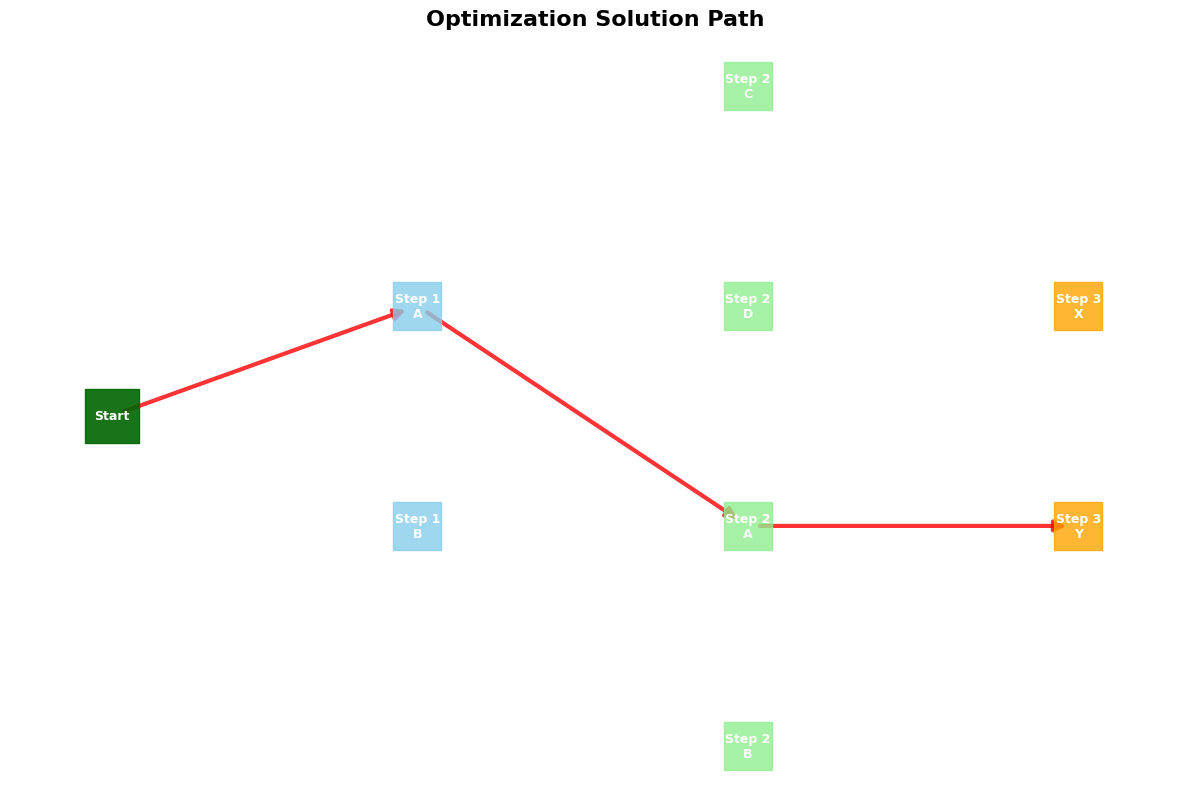


Visualization complete!
Found 3 steps with 8 total vendor options
Selected path has 3 steps


In [20]:
# Generate and display the visualization
G, pos, chosen_path = visualize_solution_from_optimizer(enhanced_optimizer)

plt.show()

print(f"\nVisualization complete!")
print(f"Found {len(enhanced_optimizer.vendors)} steps with {sum(len(v) for v in enhanced_optimizer.vendors.values())} total vendor options")
print(f"Selected path has {len(chosen_path)} steps")

# How does the solution scale?

Using the instance generator to test the scaling

In [17]:
time_to_run = []

for i in range(1,500,20):
    start_time = time.time()  # Start timing
    
    generator = random_instance_generator.Generator(i, i)
    generator.createManufacturingData()
    generator.createTransportData()
    enhanced_optimizer = EnhancedProductionOptimizer(
        "manufacturingData.csv",
        "transportData.csv",
        demand=100
    )

    # Solve using your preferred solver
    opt = pyo.SolverFactory('gurobi')
    result = opt.solve(enhanced_optimizer.model, tee=False)
    G, pos, chosen_path = visualize_solution_from_optimizer(enhanced_optimizer)
    
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    time_to_run.append(elapsed_time)  # Store the time
    
    print(f"Size {i} took {elapsed_time:.2f} seconds")
    plt.close()


Size 1 took 0.17 seconds
Size 21 took 0.06 seconds
Size 41 took 0.09 seconds
Size 61 took 0.19 seconds
Size 81 took 0.37 seconds
Size 101 took 0.69 seconds
Size 121 took 1.08 seconds
Size 141 took 1.69 seconds
Size 161 took 2.55 seconds
Size 181 took 3.55 seconds
Size 201 took 4.70 seconds
Size 221 took 6.29 seconds
Size 241 took 8.26 seconds
Size 261 took 10.31 seconds
Size 281 took 13.03 seconds
Size 301 took 16.32 seconds
Size 321 took 19.42 seconds
Size 341 took 24.00 seconds
Size 361 took 27.70 seconds
Size 381 took 32.93 seconds
Size 401 took 38.13 seconds
Size 421 took 45.56 seconds
Size 441 took 50.80 seconds
Size 461 took 71.03 seconds
Size 481 took 68.43 seconds


Text(0.5, 1.0, 'time to run for varying sizes')

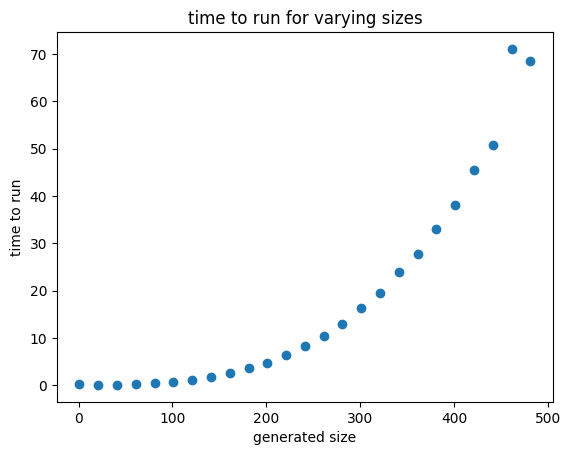

In [18]:
fig,ax = plt.subplots()
ax.scatter(range(1,500,20),time_to_run)
ax.set_xlabel("generated size")
ax.set_ylabel("time to run")
ax.set_title("time to run for varying sizes")